In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [3]:
IMAGE_SHAPE = (1000, 1000)
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

### Создадим агрегатор

In [4]:
from src.aggregate.base import Aggregator, ComposeClassifier
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.noborder import NoBorderClassifier
from src.aggregate.confidence import ConfidenceClassifier
from src.aggregate.merge import UnionMerger

In [5]:
N_CLASSES = 2
INTEGRATE_THRESHOLD = 1

In [6]:
classifier = ThresholdClassifier(N_CLASSES, INTEGRATE_THRESHOLD)
merger = UnionMerger(N_CLASSES)
gt_aggregator = Aggregator(classifier, merger)

### Интерполированный тест

In [8]:
import pickle
import json
TEST_NAME = 'sparse'
with open(f'../../../groups/gt_test_{TEST_NAME}.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'../../../groups/pred_test_{TEST_NAME}.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/{TEST_NAME}_test/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

Median group size: 21


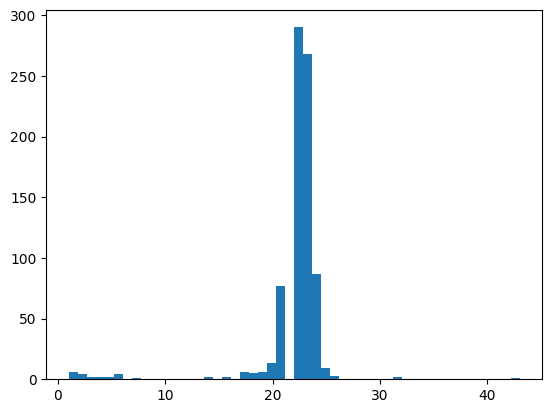

In [9]:
plt.hist([len(g) for g in gt_extended_groups], bins=50)
median_length = int(np.median([len(g) for g in pred_extended_groups]))
print(f"Median group size: {median_length}")

### Получим группы на ленте

In [10]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        conf = None
        if 'conf' in obj['obj']:
            conf = float(obj['obj']['conf'])
        obj['obj'] = shift_mask(obj['obj'], shift)
        obj['obj']['is_border'] = obj['is_border']
        if conf is not None:
            obj['obj']['conf'] = conf
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [11]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [11]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

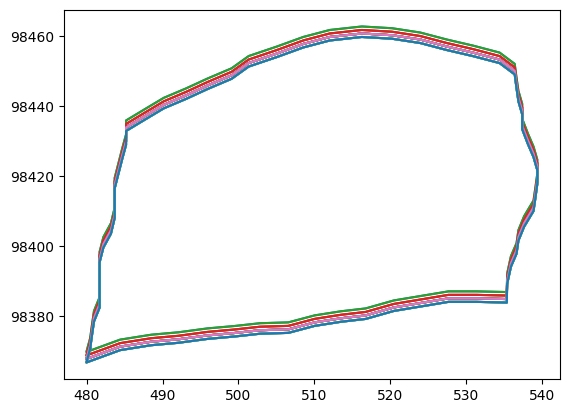

In [12]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Метрики

In [13]:
from tqdm import tqdm 

def boxes_intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check if one box is to the right of the other
    if x1 + w1 <= x2 or x2 + w2 <= x1:
        return False
        
    # Check if one box is above the other
    if y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
        
    return True

def find_matches(gt : list[dict], pred : list[dict], iou_threshold : float = 0.7):
    gt_boxes = [get_box(t) for t in gt]
    pred_boxes = [get_box(t) for t in pred]

    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)

    for i, gt_obj in tqdm(enumerate(gt), total=len(gt)):
        for j, pred_obj in enumerate(pred):
            if boxes_intersect(gt_boxes[i], pred_boxes[j]):
                iou = mask_iou(gt_obj, pred_obj)
                if iou > iou_threshold:
                    gt_matches[i] = True
                    pred_matches[j] = True
    return np.array(gt_matches), np.array(pred_matches)

In [ ]:
import numpy as np
from shapely.strtree import STRtree
from shapely.geometry import Polygon, box
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing as mp

def get_box(points):
    """Вычисление ограничивающего прямоугольника для списка точек"""
    points = np.array(points)
    return [np.min(points[:, 0]), np.min(points[:, 1]), 
            np.max(points[:, 0]), np.max(points[:, 1])]

def mask_iou_from_points(gt_points, pred_points):
    """Вычисление IoU для двух масок по их точкам"""
    gt_poly = Polygon(gt_points)
    pred_poly = Polygon(pred_points)
    
    if not gt_poly.is_valid or not pred_poly.is_valid:
        return 0.0
    
    intersection = gt_poly.intersection(pred_poly).area
    union = gt_poly.union(pred_poly).area
    
    return intersection / union if union > 0 else 0.0

def process_chunk(args):
    """Обработка пакета данных для параллельных вычислений"""
    chunk, iou_threshold = args
    chunk_results = []
    for i, j, gt_points, pred_points in chunk:
        iou = mask_iou_from_points(gt_points, pred_points)
        if iou > iou_threshold:
            chunk_results.append((i, j))
    return chunk_results

def find_matches(gt: list[dict], pred: list[dict], iou_threshold: float = 0.4):
    """Поиск совпадений между GT и предсказанными масками с использованием IoU"""
    # Извлечение точек и вычисление bounding boxes
    gt_points_list = [np.array(obj['points']) for obj in gt]
    pred_points_list = [np.array(obj['points']) for obj in pred]
    
    gt_boxes = [get_box(points) for points in gt_points_list]
    pred_boxes = [get_box(points) for points in pred_points_list]
    
    # Создание геометрий для пространственного индекса
    gt_geoms = [box(*b) for b in gt_boxes]
    pred_geoms = [box(*b) for b in pred_boxes]
    
    # Построение пространственного индекса для быстрого поиска пересечений
    tree = STRtree(pred_geoms)
    pairs_indices = []
    
    # Поиск пересекающихся пар с использованием пространственного индекса
    for i, gt_geom in enumerate(gt_geoms):
        j_indices = tree.query(gt_geom)
        for j in j_indices:
            pairs_indices.append((i, j))
    
    # Подготовка данных для параллельной обработки
    tasks = []
    chunk_size = min(1000, max(1, len(pairs_indices) // (mp.cpu_count() * 4)))
    
    for idx in range(0, len(pairs_indices), chunk_size):
        chunk = []
        for i, j in pairs_indices[idx:idx+chunk_size]:
            chunk.append((
                i, j,
                gt_points_list[i],
                pred_points_list[j]
            ))
        tasks.append((chunk, iou_threshold))
    
    # Параллельное вычисление IoU
    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)
    
    if tasks:
        with ProcessPoolExecutor() as executor:
            results = list(tqdm(
                executor.map(process_chunk, tasks),
                total=len(tasks),
                desc="Processing pairs"
            ))
            
            for chunk_results in results:
                for i, j in chunk_results:
                    gt_matches[i] = True
                    pred_matches[j] = True
    
    return np.array(gt_matches), np.array(pred_matches)

### Оптимальный агрегатор

In [ ]:
def find_best_aggregator(gt):
    thresholds = list(range(1, 10))
    confidences = np.linspace(0.35, 0.9, 12)
    remove_border_options = [False, True]
    precisions = np.zeros((len(remove_border_options), len(thresholds), len(confidences)))
    recalls    = np.zeros((len(remove_border_options), len(thresholds), len(confidences)))
    f1_scores  = np.zeros((len(remove_border_options), len(thresholds), len(confidences)))

    for i, remove_borders in enumerate(remove_border_options):
        for j, integration_threshold in enumerate(thresholds):
            for k, confidence_threshold in enumerate(confidences):
                compose_list = []
                if remove_borders:
                    compose_list.append(NoBorderClassifier(N_CLASSES, IMAGE_SHAPE))
                compose_list.append(ThresholdClassifier(N_CLASSES, integration_threshold))
                compose_list.append(ConfidenceClassifier(N_CLASSES, confidence_threshold))
                classifier = ComposeClassifier(compose_list)
                merger = UnionMerger(N_CLASSES)
                aggregator = Aggregator(classifier, merger)
                
                pred = aggregator.aggregate(pred_groups)
                gt_matches, pred_matches = find_matches(gt, pred)

                precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
                recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

                precisions[i, j, k] = precision
                recalls[i, j, k] = recall
                f1_scores[i, j, k] = f1

                print(f"No border: {remove_borders}, Integration: {integration_threshold}, Confidence: {confidence_threshold}. F1: {f1}")

    return precisions, recalls, f1_scores

In [ ]:
gt = gt_aggregator.aggregate(gt_groups)
precisions, recalls, f1_scores = find_best_aggregator(gt)

100%|██████████| 792/792 [00:40<00:00, 19.51it/s]


No border: False, Integration: 1, Confidence: 0.5. F1: 0.8693906483642139


100%|██████████| 792/792 [00:39<00:00, 19.92it/s]


No border: False, Integration: 1, Confidence: 0.55. F1: 0.8770569470326269


100%|██████████| 792/792 [00:37<00:00, 20.86it/s]


No border: False, Integration: 1, Confidence: 0.6. F1: 0.8807249890177831


100%|██████████| 792/792 [00:36<00:00, 21.67it/s]


No border: False, Integration: 1, Confidence: 0.65. F1: 0.8871105229868151


100%|██████████| 792/792 [00:34<00:00, 23.12it/s]


No border: False, Integration: 1, Confidence: 0.7. F1: 0.8765805154539289


100%|██████████| 792/792 [00:33<00:00, 23.65it/s] 


No border: False, Integration: 1, Confidence: 0.75. F1: 0.8683623594172639


100%|██████████| 792/792 [00:29<00:00, 26.47it/s] 


No border: False, Integration: 1, Confidence: 0.8. F1: 0.8369435848607474


100%|██████████| 792/792 [00:25<00:00, 31.43it/s] 


No border: False, Integration: 1, Confidence: 0.8500000000000001. F1: 0.7725182514919269


 24%|██▍       | 194/792 [00:00<00:03, 155.51it/s]

100%|██████████| 792/792 [00:10<00:00, 77.94it/s] 


No border: False, Integration: 1, Confidence: 0.9. F1: 0.39956769160635347


KeyboardInterrupt: 

In [16]:
with open(f"{TEST_NAME}_precision.pkl", 'wb') as f:
    pickle.dump(precisions, f)
with open(f"{TEST_NAME}_recalls.pkl", 'wb') as f:
    pickle.dump(recalls, f)
with open(f"{TEST_NAME}_f1_scores.pkl", 'wb') as f:
    pickle.dump(f1_scores, f)

NameError: name 'precisions' is not defined

# Анализ результатов

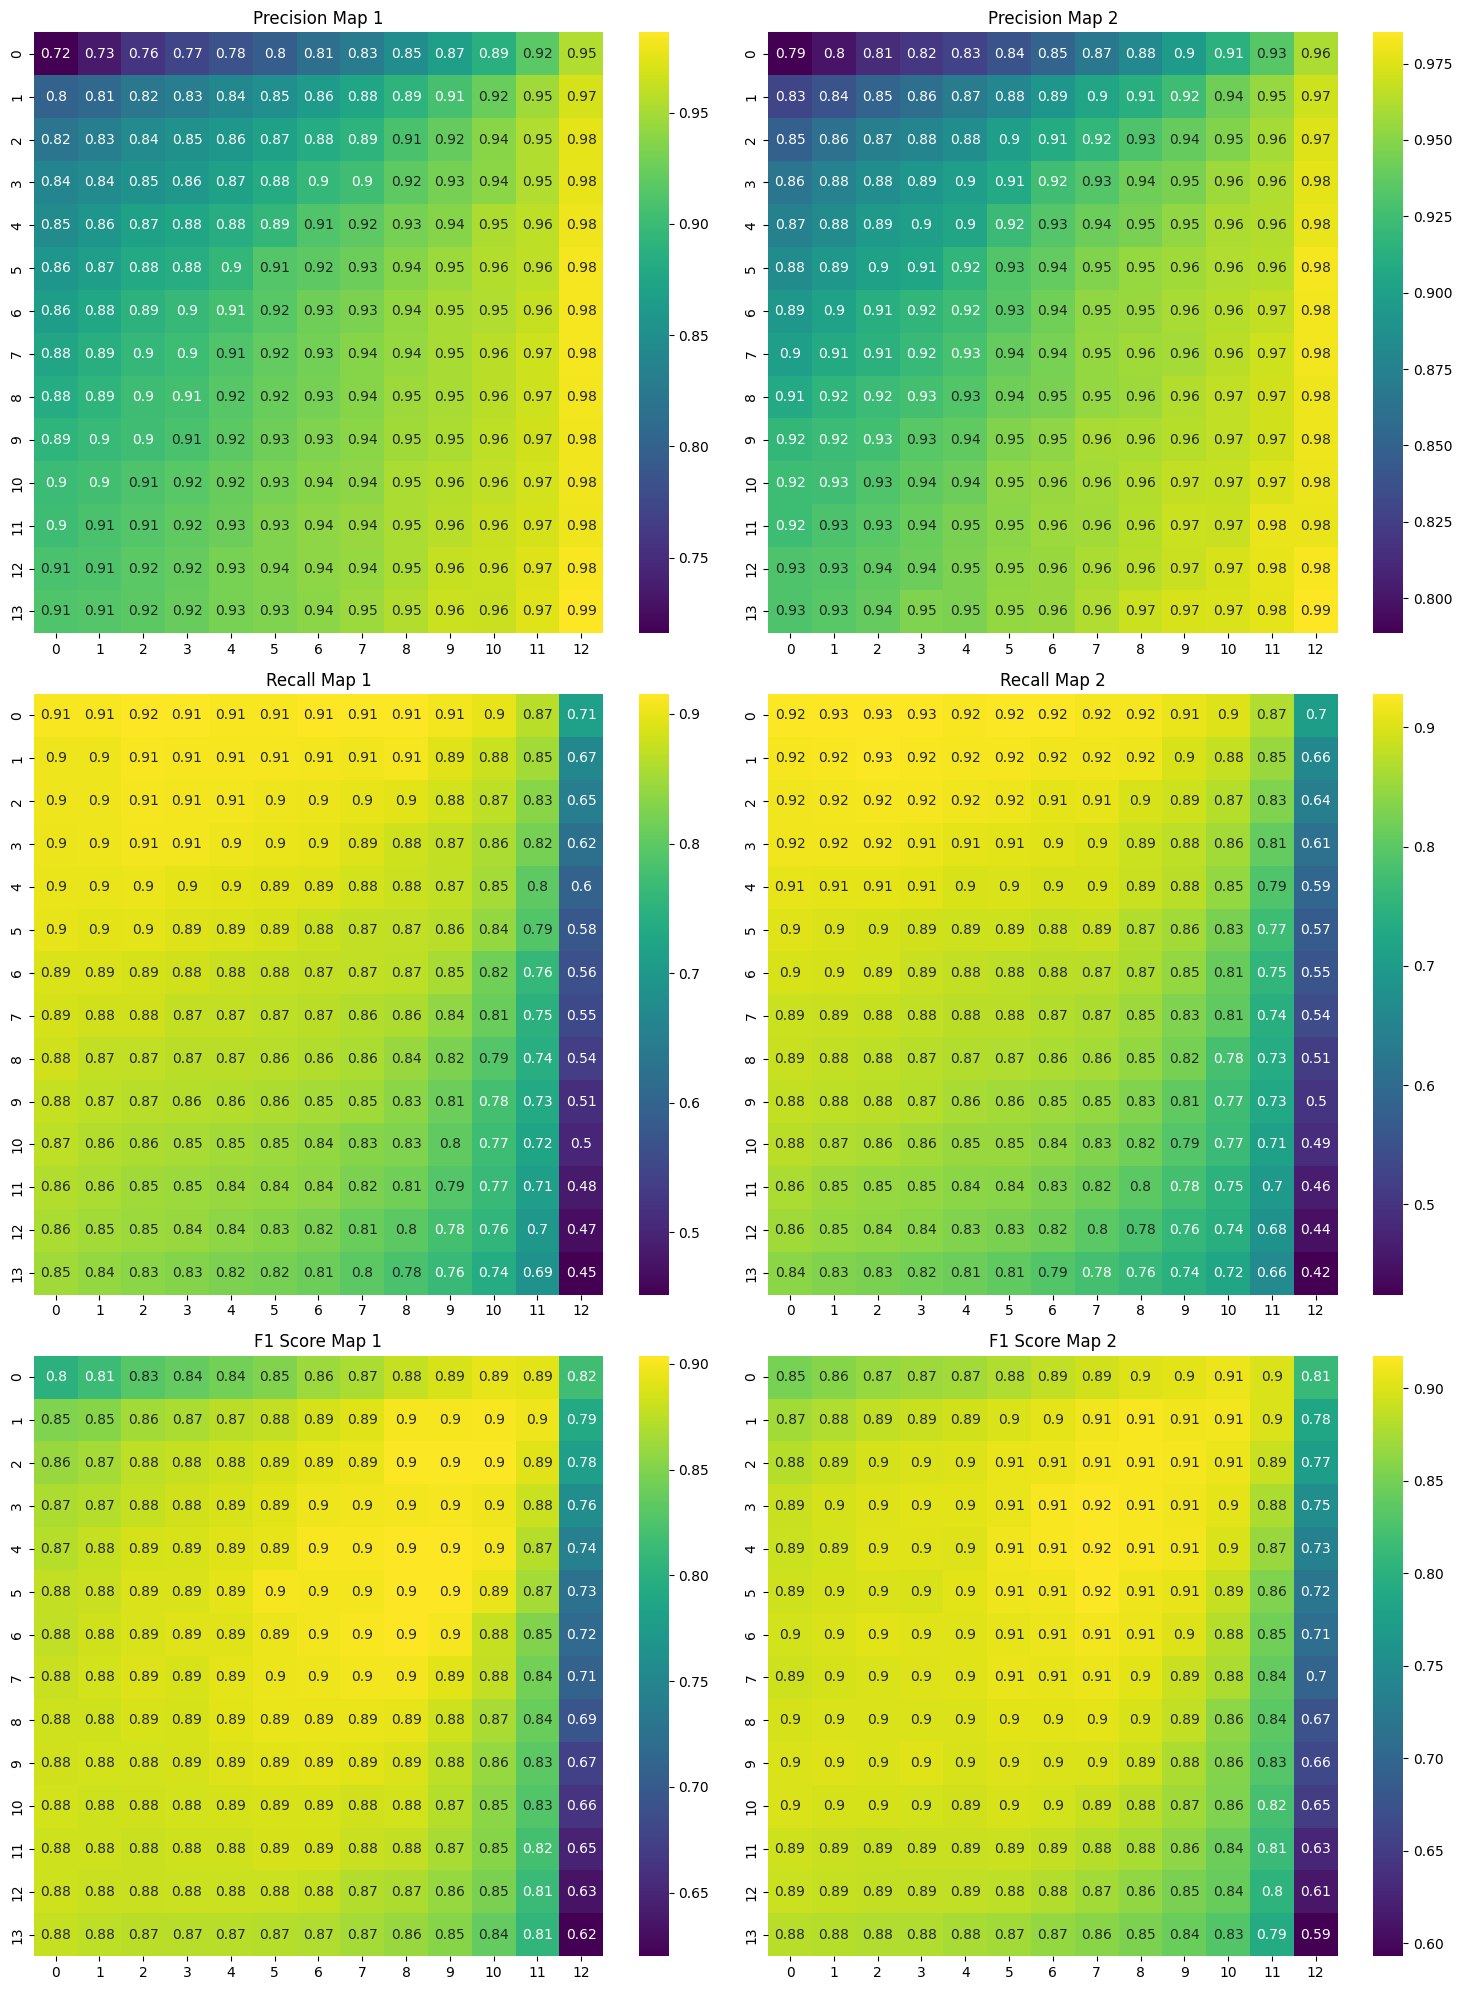

In [9]:
import pickle
with open(f"{TEST_NAME}_precision.pkl", 'rb') as f:
    precisions = pickle.load(f)
with open(f"{TEST_NAME}_recalls.pkl", 'rb') as f:
    recalls = pickle.load(f)
with open(f"{TEST_NAME}_f1_scores.pkl", 'rb') as f:
    f1_scores = pickle.load(f)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split each array into two parts
prec1, prec2 = precisions[0], precisions[1]
rec1, rec2 = recalls[0], recalls[1]
f1_1, f1_2 = f1_scores[0], f1_scores[1]

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 20))

# Plot precision heatmaps
sns.heatmap(prec1, ax=axes[0,0], cmap='viridis', annot=True)
axes[0,0].set_title('Precision Map 1')
sns.heatmap(prec2, ax=axes[0,1], cmap='viridis', annot=True)
axes[0,1].set_title('Precision Map 2')

# Plot recall heatmaps
sns.heatmap(rec1, ax=axes[1,0], cmap='viridis', annot=True)
axes[1,0].set_title('Recall Map 1')
sns.heatmap(rec2, ax=axes[1,1], cmap='viridis', annot=True)
axes[1,1].set_title('Recall Map 2')

# Plot F1 score heatmaps
sns.heatmap(f1_1, ax=axes[2,0], cmap='viridis', annot=True)
axes[2,0].set_title('F1 Score Map 1')
sns.heatmap(f1_2, ax=axes[2,1], cmap='viridis', annot=True)
axes[2,1].set_title('F1 Score Map 2')

plt.tight_layout()
plt.show()
